In [127]:
from collections import defaultdict
import geopandas
import networkx as nx
class ManHoleGraph1:
    # Assuming the network folder in the same path
    def __init__(self):
        self.graph = None
        self.df_pipe = geopandas.read_file('../data/network/Sewer_Pipe.shp')
        self.df_manhole = geopandas.read_file('../data/network/Sewer_Manhole.shp')
        self.manhole_to_coords_map = {elem['UCSD_ID']:(elem['geometry'].x,elem['geometry'].y) for _,elem in self.df_manhole[["UCSD_ID","geometry"]].iterrows()}
        self.coords_to_manhole_map = MirrorMap(self.manhole_to_coords_map).mirror
        self.edges = None
        self.graph_without_all_downstream = dict() # might not include all downstream but simplify graph
    def getSewerEdge(self):
        sewer_edges = defaultdict(set)
        for index, row in self.df_pipe.iterrows():
            for idx in range(1,len(row['geometry'].coords)):
                previous_coord, curr_coord = row['geometry'].coords[idx-1],row['geometry'].coords[idx]
                sewer_edges[previous_coord].add(curr_coord)
                graph_key = self.coords_to_manhole_map.get(previous_coord,previous_coord)
                graph_val = self.coords_to_manhole_map.get(curr_coord,curr_coord)
                self.graph_without_all_downstream[graph_key] =  graph_val
        self.edges = sewer_edges
    def getDownstream(self,seg_loc,visited,res):
        if seg_loc in visited: return
        visited.add(seg_loc)
        if seg_loc in self.coords_to_manhole_map: res.add(self.coords_to_manhole_map[seg_loc])
        for seg in self.edges[seg_loc]:
            self.getDownstream(seg,visited,res)
    def buildGraph(self):
        self.getSewerEdge()
        visited = set()
        graph = dict()
        for manhole_id in self.df_manhole['UCSD_ID']:
            if manhole_id not in visited:
                visited.add(manhole_id)
                component_sewer = set()
                self.getDownstream(self.manhole_to_coords_map[manhole_id],set(),component_sewer)
                graph[manhole_id] = component_sewer
        self.graph = graph
    def toNetworkGraph(self):
        return nx.DiGraph(self.graph)
    def toDF(self):
        G = self.toNetworkGraph()
        return nx.to_pandas_adjacency(G)
    def exportCSV(self):
        df = self.toDF()
        df.to_csv('data/downstream_graph.csv',index=False)
        print("graph csv has been saved to the data folder")
class MirrorMap:
    # take in a map and invert key and value
    def __init__(self,orginal):
        self.mirror = {value:key for key,value in orginal.items()}








In [128]:
mh_graph1 = ManHoleGraph1()
mh_graph1.buildGraph()

In [130]:
mh_graph1.graph["C7M018"]

{'C3M127',
 'C3M128',
 'C3M129',
 'C3M130',
 'C3M131',
 'C3M161',
 'C3M162',
 'C3M164',
 'C3M165',
 'C3M166',
 'C3M167',
 'C3M168',
 'C3M169',
 'C3M169A',
 'C3M170',
 'C3M171',
 'C3M172',
 'C3M174',
 'C3M175',
 'C3M229',
 'C3M230',
 'C3M231',
 'C7M001',
 'C7M002',
 'C7M017',
 'C7M018',
 'C7M026'}

## Study unmatched manholes

In [ ]:
mh_graph.manhole_to_coords_map

In [111]:
segment_with_points = [[coord for coord in elem.coords] for elem in list(mh_graph.df_pipe["geometry"])]
segment_set = set(elem for arry in segment_with_points for elem in arry)
len(segment_set)

4586

In [113]:
set(mh_graph.coords_to_manhole_map) - set(segment_set)

{(6253798.525415838, 1897334.4664702564),
 (6257412.283280179, 1903539.8224978447),
 (6259489.70825918, 1899317.2850111723)}

In [47]:
test_geo1 = mh_graph.df_pipe[mh_graph.df_pipe['UCSD_ID'] == "S02378"]['geometry'].iloc[0]
test_mh1 = mh_graph.df_manhole[mh_graph.df_manhole['UCSD_ID'] == 'C3M110']['geometry'].iloc[0]

In [49]:
test_geo1.distance(test_mh1)

0.10170583426952362

In [50]:
test_geo2 = mh_graph.df_pipe[mh_graph.df_pipe['UCSD_ID'] == "S02419"]['geometry'].iloc[0]
test_mh2 = mh_graph.df_manhole[mh_graph.df_manhole['UCSD_ID'] == 'C3M257']['geometry'].iloc[0]
test_geo2.distance(test_mh2)

0.0

In [68]:
len(mh_graph.graph)

631

In [110]:
segment_with_points = [[coord for coord in elem.coords] for elem in list(mh_graph.df_pipe["geometry"])]
segment_set = set(elem for arry in segment_with_points for elem in arry)
len(segment_set)

4586

In [71]:
len(set(mh_graph.coords_to_manhole_map).intersection(set(mh_graph.edges)))

631

In [106]:
len(set(mh_graph.edges))

4519

## Three fixes:
    1. Add Tolerance 0.2 ~ 0.5
    2. Get official flows

In [54]:
mh_graph.df_pipe[mh_graph.df_pipe["SLOPE"]<0]

OBJECTID UCSD_ID STATUS      PRESSURE  SIZE   MATERIAL   IE_UP   IE_DN  \
11          12  S00524      N    FORCE MAIN   2.0        PVC  388.00  390.80   
13          14  S00540      N  GRAVITY MAIN   6.0        VCP    0.00  404.00   
55          57  S01189      N  GRAVITY MAIN   6.0        PVC  406.68  408.53   
65          67  S00885      N  GRAVITY MAIN   0.0        N/A  339.16  345.66   
71          73  S01173      Y    FORCE MAIN   8.0        PVC  383.10  391.00   
...        ...     ...    ...           ...   ...        ...     ...     ...   
2305      2472  S00875      N  GRAVITY MAIN  10.0        PVC    0.00  318.70   
2319       583  S01793      N  GRAVITY MAIN   8.0  CAST IRON    0.00  374.71   
2348       680  S01580      N  GRAVITY MAIN   4.0        N/A    0.00  410.00   
2360      1179  S00955      N  GRAVITY MAIN   6.0        PVC    0.00  327.40   
2368      1017  S00831      N  GRAVITY MAIN   4.0        PVC    0.00  311.50   

          SLOPE  INSTALL_DA  ...                                GLOBALID  \
11    -0.029037  1980-12-16  ...  {AB62ED2E-85F7-48D0-BD4A-AE7C6D84A840}   
13    -3.996768  1966-07-02  ...  {DC87BDBC-9955-4A19-AF22-D77B227F20AD}   
55    -0.249781  2007-11-30  ...  {A4FE85A9-BC3A-4A6F-9C23-0816DB2026B8}   
65    -0.880526  1991-04-15  ...  {9BF75E7C-F569-4C4D-BB74-636079F86F89}   
71    -0.016113  2004-06-30  ...  {398591BC-ADCD-4275-85B7-41DE4879FF15}   
...         ...         ...  ...                                     ...   
2305  -4.541766        None  ...  {EE25D046-267D-4EA2-81F5-E1B974825788}   
2319  -2.006500  1961-12-31  ...  {71D64DD1-45C9-46F0-9C8F-5F16539B88F1}   
2348 -21.057518  1974-02-20  ...  {033178C5-C225-4B61-8699-DF581C72876D}   
2360  -1.707562  1984-01-16  ...  {611C780B-DA58-4ABE-B0DB-048ED71B3693}   
2368  -6.461799  1987-03-21  ...  {BD17A026-D08F-493C-BEE6-094727D6039D}   

     FLOWDIRECT FLOWDIRE_1 FLOWDIRE_2 FLOWDIRE_3  Shape_Le_1 FLOWDIRE_4  \
11            1          1          1          1   96.427335          1   
13            1          1          1          1  101.081677          1   
55            1          1          1          1    7.406473          1   
65            1          1          1          1    7.381949          1   
71            1          1          1          1  490.275594          1   
...         ...        ...        ...        ...         ...        ...   
2305          1          1          1          1   10.042316          1   
2319          1          1          1          1   77.537779          1   
2348          1          1          1          1    4.340991          1   
2360          1          1          1          1    6.013333          1   
2368          1          1          1          1    2.850979          1   

      FLOWDIRE_5 FLOWDIRE_6                                           geometry  
11             1          1  LINESTRING (6257654.385 1900122.283, 6257747.1...  
13             1          1  LINESTRING (6257190.908 1899608.046, 6257194.1...  
55             1          1  LINESTRING (6257254.635 1903883.541, 6257260.8...  
65             1          1  LINESTRING (6259630.402 1900919.081, 6259632.1...  
71             1          1  LINESTRING (6257004.106 1903780.701, 6257004.1...  
...          ...        ...                                                ...  
2305           1          1  LINESTRING (6259732.151 1901028.087, 6259738.0...  
2319           1          1  LINESTRING (6255641.166 1898074.603, 6255641.2...  
2348           1          1  LINESTRING (6257944.161 1901639.044, 6257947.4...  
2360           1          1  LINESTRING (6259811.366 1902648.628, 6259816.4...  
2368           1          1  LINESTRING (6260532.421 1900582.946, 6260529.6...  

[164 rows x 38 columns]

In [63]:
set(mh_graph.df_pipe["FLOWDIRE_6"])

{1}

In [164]:
segment_with_points = [[coord for coord in elem.coords] for elem in list(mh_graph.df_pipe["geometry"])]
segment_set = set(elem for arry in segment_with_points for elem in arry)
len(segment_set)

4586

In [165]:
manhole_coords = [(elem.x,elem.y)for elem in list(mh_graph.df_manhole["geometry"])]

In [166]:
segment_with_points = [[coord for coord in row['geometry'].coords] for index, row in mh_graph.df_pipe.iterrows()]
segment_set = set(elem for arry in segment_with_points for elem in arry)
len(segment_set)

4586

In [168]:
segment_with_points_no_intersect = [[row['geometry'].coords[0],row['geometry'].coords[-1]] for index, row in mh_graph.df_pipe.iterrows()]
segment_set = set(elem for arry in segment_with_points for elem in arry)
len(segment_set)

4586

In [169]:
len(segment_set.intersection(set(manhole_coords)))

628

In [96]:
segment_with_points3 = [coord for index, row in mh_graph.df_pipe.iterrows() for coord in row['geometry'].coords]
segment_set3 = set(segment_with_points3)
len(segment_set3)

4586

In [97]:
segment_set4 = set()
for index, row in mh_graph.df_pipe.iterrows():
    for coord in row['geometry'].coords:
        segment_set4.add(coord)
len(segment_set4)

4586

In [99]:
segment_set5 = set()
for index, row in mh_graph.df_pipe.iterrows():
    for idx in range(1,len(row['geometry'].coords)):
        previous_coord, curr_coord = row['geometry'].coords[idx-1],row['geometry'].coords[idx]
        segment_set5.add(previous_coord)
len(segment_set5)

4457

In [107]:
set(mh_graph.edges)-segment_set5

{(6253405.713209346, 1895662.8457977623),
 (6253427.863755584, 1896400.3777872622),
 (6253465.2488514185, 1896453.2195450962),
 (6253559.803124264, 1896351.284053415),
 (6253798.525415838, 1897334.4664702564),
 (6253824.22713609, 1897092.359014839),
 (6253893.061972171, 1897854.101913929),
 (6253937.513983011, 1897944.049568668),
 (6253959.792809844, 1897795.0541317612),
 (6253997.582432419, 1898007.2289042622),
 (6254203.866468668, 1897801.4537252486),
 (6254735.612124339, 1896055.0362863392),
 (6254739.633113667, 1895697.3240752518),
 (6254744.807315931, 1896262.4089030921),
 (6254759.549084336, 1895888.015951082),
 (6254759.593047515, 1895958.5312300026),
 (6256535.029129177, 1905356.2880250067),
 (6256604.347888172, 1903795.4857004285),
 (6256662.948820844, 1903836.4249230027),
 (6256662.948820844, 1903842.4301603436),
 (6256662.9704743475, 1903848.4124318361),
 (6256880.557965681, 1905718.285332501),
 (6257004.106275007, 1903783.8830333352),
 (6257009.215188667, 1903244.5845712572

In [109]:
mh_graph.edges[(6253405.713209346, 1895662.8457977623)]

set()

In [115]:
from zipfile import ZipFile

with ZipFile('UCSDTracev2.gdb.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [2]:
import os
os.environ['GDAL_DATA']

'/Users/yijianzong/anaconda3/envs/gdal_test/share/gdal'

In [8]:
! pip install gdal

  Using cached https://files.pythonhosted.org/packages/86/01/03d442f8765eaf19ba24260c874df502309a61f4a58a6483b6107f749990/GDAL-3.2.1.tar.gz
  Complete output from command /Users/yijianzong/anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/9p/syddkr317_ddsqc3gsl3crmm0000gn/T/pip-install-zt8ao7vd/gdal/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /private/var/folders/9p/syddkr317_ddsqc3gsl3crmm0000gn/T/pip-wheel-73m4mk6_ --python-tag cp37:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.7
  creating build/lib.macosx-10.9-x86_64-3.7/osgeo
  copying osgeo/gnm.py -> build/lib.macosx-10.9-x86_64-3.7/osgeo
  copying osgeo/__init__.py -> build/lib.macosx-10.9-x86_64-3.7/osgeo
  copying osgeo/gdalnumeric.py -> build/lib.macosx-10.9-x86_64-3.7/osgeo
  copying osgeo/osr.py -> build/lib.m

Failed to build gdal
  Running setup.py install for gdal ... error
    Complete output from command /Users/yijianzong/anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/9p/syddkr317_ddsqc3gsl3crmm0000gn/T/pip-install-zt8ao7vd/gdal/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /private/var/folders/9p/syddkr317_ddsqc3gsl3crmm0000gn/T/pip-record-xs2acsms/install-record.txt --single-version-externally-managed --compile:
    running install
    running build
    running build_py
    creating build
    creating build/lib.macosx-10.9-x86_64-3.7
    creating build/lib.macosx-10.9-x86_64-3.7/osgeo
    copying osgeo/gnm.py -> build/lib.macosx-10.9-x86_64-3.7/osgeo
    copying osgeo/__init__.py -> build/lib.macosx-10.9-x86_64-3.7/osgeo
    copying osgeo/gdalnumeric.py -> build/lib.macosx-10.9-x86_64-3.7/osgeo
    copying osgeo/osr.py -> build/lib.macosx

You are using pip version 19.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import fiona 
import geopandas as gpd

# Get all the layers from the .gdb file 
layers = fiona.listlayers("UCSDTracev2.gdb")
layers

['Sewer_Buildings',
 'Sewer_Manhole',
 'City_Sewer_Pipe',
 'Sewer_Cleanout',
 'Sewer_Misc',
 'Sewer_Pipe',
 'AddLine',
 'Sewer_Trace',
 'TN_79_DirtyAreas',
 'TN_79_Associations',
 'TN_79_PointErrors',
 'TN_79_LineErrors',
 'TN_79_TraceConfigurations',
 'TN_79_Templates',
 'TN_79_Diagrams',
 'TN_79_Edges',
 'TN_79_Junctions',
 'TN_79_Containers',
 'TN_79_Aggregations',
 'TN_79_Relations',
 'TN_79_TmpDiagrams',
 'TN_79_TmpEdges',
 'TN_79_TmpJunctions',
 'TN_79_TmpContainers',
 'TN_79_TmpAggregations',
 'TN_79_TmpRelations']

In [62]:
gdf = gpd.read_file("UCSDTracev2.gdb",layer='Sewer_Manhole')
# Do stuff with the gdf
gdf

OBJECTID UCSD_ID             TYPE    IE                         SDRSD  \
0           1  C3M073  4' x 3' Manhole  None                       SDS-107   
1           2  C2M029  4' x 3' Manhole  None  BIOMEDICAL FACILITY II C5.01   
2           3  C2M032  4' x 3' Manhole  None  BIOMEDICAL FACILITY II C5.01   
3           4  C2M031  4' x 3' Manhole  None  BIOMEDICAL FACILITY II C5.01   
4           5  C2M030  4' x 3' Manhole  None  BIOMEDICAL FACILITY II C5.01   
..        ...     ...              ...   ...                           ...   
626       695  C6M095  5' x 3' Manhole  None                       SDS-106   
627       696  C6M094  5' x 3' Manhole  None                       SDS-106   
628       697  C6M096  5' x 3' Manhole  None                       SDS-106   
629       698  C6M097  5' x 3' Manhole  None                       SDS-106   
630       699  C6M098  5' x 3' Manhole  None                       SDS-106   

              INSTALL_DA                                           AS_BUILT  \
0    1978-11-03T00:00:00  https://facilities.ucsd.edu/Drawings/home/shee...   
1    2010-12-01T00:00:00                   BIO MEDICIAL RESEARCH PH2 C3. 01   
2    2010-12-01T00:00:00                   BIO MEDICIAL RESEARCH PH2 C3. 01   
3    2010-12-01T00:00:00                   BIO MEDICIAL RESEARCH PH2 C3. 01   
4    2010-12-01T00:00:00                   BIO MEDICIAL RESEARCH PH2 C3. 01   
..                   ...                                                ...   
626  2018-05-16T00:00:00                                       EAST 1 C-132   
627  2018-05-16T00:00:00                                       EAST 1 C-131   
628  2018-05-16T00:00:00                                       EAST 1 C-131   
629  2018-05-16T00:00:00                                       EAST 1 C-133   
630  2018-05-16T00:00:00                                       EAST 1 C-133   

                            LOCATION MAINT_BY MAINT_DATE INFO_SOURC  \
0                           HILLSIDE       NA       None              
1    Biomedical Research Facility II       NA       None              
2    Biomedical Research Facility II       NA       None              
3    Biomedical Research Facility II       NA       None              
4    Biomedical Research Facility II       NA       None              
..                               ...      ...        ...        ...   
626                       Nuevo East       NA       None              
627                       Nuevo East       NA       None              
628                       Nuevo East       NA       None              
629                       Nuevo East       NA       None              
630                       Nuevo East       NA       None              

    PIC_SURVEY NOTES created_us created_da last_edite           last_edi_1  \
0          N/A   N/A                  None   AINCIONG  2016-10-13T00:00:00   
1          N/A   N/A                  None   AINCIONG  2016-10-13T00:00:00   
2          N/A   N/A                  None   AINCIONG  2016-10-13T00:00:00   
3          N/A   N/A                  None   AINCIONG  2016-10-13T00:00:00   
4          N/A   N/A                  None   AINCIONG  2016-10-13T00:00:00   
..         ...   ...        ...        ...        ...                  ...   
626                                   None         ND  2020-06-18T00:00:00   
627                                   None         ND  2020-06-18T00:00:00   
628                                   None         ND  2020-06-18T00:00:00   
629                                   None         ND  2020-06-18T00:00:00   
630                                   None         ND  2020-06-18T00:00:00   

                                   GLOBALID                         geometry  
0    {8A132BDD-1C1B-4D3F-B114-0F1AB76844F5}  POINT (6260385.853 1900673.053)  
1    {5A7349A9-9684-42CA-A5E3-4217B5FA5A3C}  POINT (6259334.252 1899321.881)  
2    {41B1206B-14C8-4C60-A57E-78B00BE185CE}  POINT (6259141.414 1899150.965)  
3    {8A6BD0F

In [16]:
chr(92)

'\\'

In [34]:
df_sewer_trace = gpd.read_file('../data/network/Sewer_Trace.shp')

In [31]:
mh_graph.edges.get((6253214.117,1894989.241),"lol")

'lol'

In [30]:
gpd.read_file('../data/network/Sewer_Misc.shp').columns

Index(['OBJECTID', 'UCSD_ID', 'TYPE', 'IE', 'SDRSD', 'INSTALL_DA', 'AS_BUILT',
       'LOCATION', 'MAINT_BY', 'MAINT_DATE', 'INFO_SOURC', 'PIC_SURVEY',
       'NOTES', 'created_us', 'created_da', 'last_edite', 'last_edi_1',
       'GLOBALID', 'geometry'],
      dtype='object')

In [65]:
list(mh_graph.df_pipe['geometry'][0].coords)

[(6258198.488400668, 1900145.8768579215),
 (6258125.227392346, 1900113.9868298322)]

In [72]:
slopes = [(elem.coords[-1][1]-elem.coords[0][1])/(elem.coords[-1][0]-elem.coords[0][0]+1)for elem in mh_graph.df_pipe['geometry']]

In [74]:
mh_graph.df_pipe['SLOPE']

0       0.008761
1       0.020139
2       0.008563
3       0.020129
4       0.009542
          ...   
2380    0.178231
2381    0.000000
2382    0.000000
2383    0.000000
2384    0.000000
Name: SLOPE, Length: 2385, dtype: float64

In [73]:
slopes

[0.4413172308235073,
 36.99668161006026,
 21.989092162892657,
 -96.15789262521595,
 -0.6900104034241213,
 -0.00018302112127729973,
 -0.00017404060401502445,
 -1.9854115164310067,
 -1.5284250021030652,
 0.9190371769320833,
 -3.0683526870451994,
 0.2805614879044507,
 -32.039580329302915,
 0.08184919353078988,
 -56.914134409706705,
 -26.616378369701447,
 0.021524750081675113,
 -0.017069224397884376,
 -0.022621554280751896,
 -0.0038980886822735945,
 -0.9906659498833171,
 -121.33397056347597,
 -1.1163645094728203,
 0.41581985747582795,
 -0.009108876749176436,
 -0.0008193405878640558,
 10.395413029491127,
 -17.844099928545674,
 4.062148186958491e-06,
 -71.17609667379622,
 -36.861908815042014,
 -6.747822524954746,
 -57.280829982017316,
 0.0,
 -0.8000553663789507,
 0.0005995502517122609,
 0.0005397226183949384,
 -0.001638702278888828,
 12.998360993109005,
 0.5782992802671298,
 -15.168297756157429,
 -0.6700677211500023,
 -0.0015352326913894512,
 -0.010348003271015151,
 -0.5712182233111645,
 -0.

In [67]:
mh_graph.df_pipe['SLOPE'][0]

0.00876085565382

In [36]:
set(mh_graph.df_pipe['GLOBALID']).intersection(df_sewer_trace['GLOBALID'])

set()

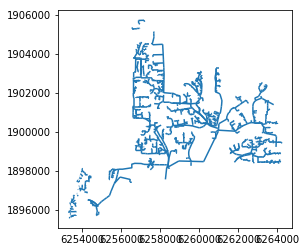

In [41]:
mh_graph.df_pipe.plot();

In [1]:
# import the GIS class in gis module
from copy import deepcopy
import datetime as dt
from IPython.display import HTML
import json
import pandas as pd
from arcgis.gis import GIS
import arcgis.network as network
import arcgis.geocoding as geocoding
from arcgis.features import FeatureLayer, FeatureSet, FeatureCollection
import arcgis.features.use_proximity as use_proximity

/Users/yijianzong/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/Users/yijianzong/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,

In [2]:
print("ArcGIS Online Org account")    
gis = GIS("https://www.arcgis.com", "yizong_DSC180A", "Du83887199")
print("Logged in as " + str(gis.properties.user.username))

ArcGIS Online Org account
Logged in as yizong_DSC180A


<Item title:"Sewer_Pipe_trace" type:Feature Layer Collection owner:yizong_DSC180A>
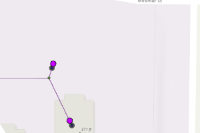

In [4]:
tester_content = gis.content.search("owner:yizong_DSC180A")
tester_content[5]

In [6]:
cloned_layer_trace = tester_content[5].layers[0]
ports_fset = cloned_layer_trace.query()
ports_features = ports_fset.features
one_feature = [f for f in ports_features][0]

In [7]:
pf1 = list(ports_fset.features)[20]

In [8]:
pf1

{"geometry": {"paths": [[[6257520.32833968, 1898503.92935443], [6257523.09933151, 1898501.14884818], [6257597.74616385, 1898426.24348617]]]}, "attributes": {"OBJECTID_1": 21, "OBJECTID": 21, "UCSD_ID": "S00549", "STATUS": "N", "PRESSURE": "GRAVITY MAIN", "SIZE": 8, "MATERIAL": "PVC", "IE_UP": 409.85, "IE_DN": 405.8, "SLOPE": 0.0369272728827, "INSTALL_DA": 840672000000, "AS_BUILT": "https://facilities.ucsd.edu/Drawings/home/sheets/default.htm?Skey=53414, 32306", "LOCATION": "EAST OF MANDELL WEISS FORUM", "MAINT_BY": " ", "MAINT_DATE": null, "INFO_SOURC": " ", "PIC_SURVEY": "N/A", "NOTES": "N/A", "LENGTH": 109.675036466, "created_us": " ", "created_da": null, "last_edite": "AINCIONG", "last_edi_1": 1476316800000, "Shape_Leng": 109.675036466, "CCTV_Date": 1504742400000, "CCTV_By": "Affordable Pipe Cleaning", "Severity": " ", "Cleaned_Da": null, "Inspection": " ", "GLOBALID": "57bc0125-5d09-405a-8005-0e7bffb88dab", "FLOWDIRECTION": 1, "FLOWDIRECTION_1": 1, "FLOWDIRECTION_2": 1, "FLOWDIRECT

In [22]:
my_content = gis.content.search("Sewer_Manhole_trace owner:yizong_DSC180A")
cloned_manhole_trace = my_content[0].layers[0]

In [26]:
pipe_data = cloned_layer_trace.query().features
manhole_data = cloned_manhole_trace.query().features

In [59]:
pipe_data[0].geometry['paths'][0]

[[6258198.48840067, 1900145.87685792], [6258125.22739235, 1900113.98682983]]

In [38]:
manhole_data[0].attributes['UCSD_ID']

'C3M073'

In [105]:
from collections import defaultdict
import geopandas
import networkx as nx
class ManHoleGraph2:
    # Assuming the network folder in the same path
    def __init__(self,pipe_data,manhole_data):
        self.graph = None
        self.pipe_data = pipe_data
        self.manhole_data = manhole_data
        self.manhole_to_coords_map = {elem.attributes['UCSD_ID']:(elem.geometry['x'],elem.geometry['y']) for elem in self.manhole_data}
        self.coords_to_manhole_map = MirrorMap(self.manhole_to_coords_map).mirror
        self.edges = None
        self.graph_without_all_downstream = dict() # might not include all downstream but simplify graph
    def getSewerEdge(self):
        sewer_edges = defaultdict(set)
        for row in self.pipe_data:
            for idx in range(1,len(row.geometry['paths'][0])):
                previous_coord, curr_coord = tuple(row.geometry['paths'][0][idx-1]),tuple(row.geometry['paths'][0][idx])
                sewer_edges[previous_coord].add(curr_coord)
                graph_key = self.coords_to_manhole_map.get(previous_coord,previous_coord)
                graph_val = self.coords_to_manhole_map.get(curr_coord,curr_coord)
                self.graph_without_all_downstream[graph_key] =  graph_val
        self.edges = sewer_edges
    def getDownstream(self,seg_loc,visited,res):
        if seg_loc in visited: return
        visited.add(seg_loc)
        if seg_loc in self.coords_to_manhole_map: res.add(self.coords_to_manhole_map[seg_loc])
        for seg in self.edges[seg_loc]:
            self.getDownstream(seg,visited,res)
    def buildGraph(self):
        self.getSewerEdge()
        visited = set()
        graph = dict()
        for manhole_id in [elem.attributes['UCSD_ID'] for elem in self.manhole_data]:
            if manhole_id not in visited:
                visited.add(manhole_id)
                component_sewer = set()
                self.getDownstream(self.manhole_to_coords_map[manhole_id],set(),component_sewer)
                graph[manhole_id] = component_sewer
        self.graph = graph
    def toNetworkGraph(self):
        return nx.DiGraph(self.graph)
    def toDF(self):
        G = self.toNetworkGraph()
        return nx.to_pandas_adjacency(G)
    def exportCSV(self):
        df = self.toDF()
        df.to_csv('data/downstream_graph.csv',index=False)
        print("graph csv has been saved to the data folder")
class MirrorMap:
    # take in a map and invert key and value
    def __init__(self,orginal):
        self.mirror = {value:key for key,value in orginal.items()}

In [106]:
test_mh = ManHoleGraph2(pipe_data,manhole_data)

In [109]:
test_mh.buildGraph()

In [110]:
len(set(test_mh.edges).intersection(set(test_mh.coords_to_manhole_map)))

631

## Verify Shape files versus online Arcgis

In [99]:
def verifyOrder(pipe_data,pipe_df):
    mistakes = 0
    for index, row in pipe_df.iterrows():
        for idx in range(0,len(row['geometry'].coords)):
            x1, y1 = row['geometry'].coords[idx][0],row['geometry'].coords[idx][1]
            x2, y2 = pipe_data[index].geometry['paths'][0][idx][0],pipe_data[index].geometry['paths'][0][idx][1]
            if not (math.isclose(x1,x2) and math.isclose(y1,y2)):mistakes+=1
    return mistakes

In [101]:
import math
pipe_df = geopandas.read_file('../data/network/Sewer_Pipe.shp')
verifyOrder(pipe_data,pipe_df)

0

## Refactor with tolerance

In [215]:
import geopandas
from collections import defaultdict
import networkx as nx
class MirrorMap:
    # take in a map and invert key and value
    def __init__(self,original):
        try:
            self.mirror = {value:key for key,value in original.items()}
        except TypeError:
            self.mirror = defaultdict(set)
            for key,neighbors in original.items():
                for n in neighbors:
                    self.mirror[n].add(key)
class TraceGraph:
    # Assuming the network folder in the same path
    def __init__(self):
        self.graph = None
        self.manhole_graph = None
        self.trace_graph = None
        self.df_pipe = geopandas.read_file('../data/network/Sewer_Pipe.shp')
        self.df_manhole = geopandas.read_file('../data/network/Sewer_Manhole.shp')
        self.df_buildings= geopandas.read_file('../data/network/Sewer_Buildings.shp')
        self.manhole_to_coords_map = {elem['UCSD_ID']:(elem['geometry'].x,elem['geometry'].y) for _,elem in self.df_manhole[["UCSD_ID","geometry"]].iterrows()}
        self.coords_to_manhole_map = MirrorMap(self.manhole_to_coords_map).mirror
        self.build_to_coords_map = {elem['CAANtext']:(elem['geometry'].x,elem['geometry'].y) for _,elem in self.df_buildings[["CAANtext","geometry"]].iterrows() if elem['CAANtext']}
        self.coords_to_build_map = MirrorMap(self.build_to_coords_map).mirror
        self.edges = None
        self.mirror_edges = None
        self.graph_without_all_downstream = dict() # might not include all downstream but simplify graph
    def getSewerEdge(self):
        sewer_edges = defaultdict(set)
#         for index, row in self.df_pipe.iterrows():
#             previous_coord, curr_coord = row['geometry'].coords[0],row['geometry'].coords[-1]
#             sewer_edges[previous_coord].add(curr_coord)
#             graph_key = self.coords_to_manhole_map.get(previous_coord,previous_coord)
#             graph_val = self.coords_to_manhole_map.get(curr_coord,curr_coord)
#             self.graph_without_all_downstream[graph_key] =  graph_val
        for index, row in self.df_pipe.iterrows():
            for idx in range(1,len(row['geometry'].coords)):
                previous_coord, curr_coord = row['geometry'].coords[idx-1],row['geometry'].coords[idx]
                sewer_edges[previous_coord].add(curr_coord)
                graph_key = self.coords_to_manhole_map.get(previous_coord,previous_coord)
                graph_val = self.coords_to_manhole_map.get(curr_coord,curr_coord)
                self.graph_without_all_downstream[graph_key] =  graph_val
        self.edges = sewer_edges
        self.mirror_edges = MirrorMap(self.edges).mirror
    def getFlow(self,seg_loc,visited,res,origin,mode="downstream",only_mode=None):
        if seg_loc in visited: return
        visited.add(seg_loc)
        if (seg_loc in self.coords_to_manhole_map) and (self.coords_to_manhole_map[seg_loc] != origin) and ((not only_mode) or only_mode == "manhole"): 
            res.add(self.coords_to_manhole_map[seg_loc])
        if (seg_loc in self.coords_to_build_map) and (self.coords_to_build_map[seg_loc] != origin)  and ((not only_mode) or only_mode == "build"): 
            res.add(self.coords_to_build_map[seg_loc])
        if mode == "downstream":
            for seg in self.edges[seg_loc]:
                self.getFlow(seg,visited,res,origin,mode,only_mode)
        else:
            for seg in self.mirror_edges[seg_loc]:
                self.getFlow(seg,visited,res,origin,mode,only_mode)
    def buildGraph(self):
        self.getSewerEdge()
        visited = set()
        graph = dict()
        # Build downward manhole graph
        for manhole_id in self.df_manhole['UCSD_ID']:
            if manhole_id not in visited:
                visited.add(manhole_id)
                component_sewer = set()
                self.getFlow(self.manhole_to_coords_map[manhole_id],set(),component_sewer,manhole_id,"downstream","manhole")
                graph[manhole_id] = component_sewer
        self.manhole_graph = graph
        # Build upward tracing graph
        visited = set()
        graph = dict()
        for manhole_id in self.df_manhole['UCSD_ID']:
            if manhole_id not in visited:
                visited.add(manhole_id)
                component_sewer = set()
                self.getFlow(self.manhole_to_coords_map[manhole_id],set(),component_sewer,manhole_id,"upstream","build")
                graph[manhole_id] = component_sewer
        self.trace_graph = graph
        # Build the main graph
        visited = set()
        graph = defaultdict(set)
        for key,value in self.mirror_edges.items():
            temp_key = key
            if (key in self.coords_to_build_map):temp_key = self.coords_to_build_map[key]
            if (key in self.coords_to_manhole_map):temp_key = self.coords_to_manhole_map[key]
            for val in value:
                temp_val = val
                if (val in self.coords_to_build_map):temp_val = self.coords_to_build_map[val]
                if (val in self.coords_to_manhole_map):temp_val = self.coords_to_manhole_map[val]
                graph[temp_key].add(temp_val)
        self.graph = graph
    def toNetworkGraph(self,g_type="manhole"):
        if g_type == "manhole":
            return nx.DiGraph(self.manhole_graph)
        if g_type == "trace":
            return nx.DiGraph(self.trace_graph)
        return nx.DiGraph(self.graph)
    def topoSort(self,g_type="trace"):
        # build to other map
        return list(nx.topological_sort(self.toNetworkGraph(g_type)))
    def toDF(self):
        G = self.toNetworkGraph()
        return nx.to_pandas_adjacency(G)
    def exportCSV(self):
        df = self.toDF()
        df.to_csv('data/downstream_graph.csv',index=False)
        print("graph csv has been saved to the data folder")
                        
                    
                
        




In [171]:
def getFlow2(target,seg_loc,visited,res,origin,mode="downstream",only_mode=None):
    if seg_loc in visited: return
    if seg_loc == target: 
        res.append(mh_graph.coords_to_manhole_map[seg_loc])
        print("found it!")
        return 
    visited.add(seg_loc)
    if (seg_loc in mh_graph.coords_to_manhole_map) and ((not only_mode) or only_mode == "manhole"): 
        res.append(mh_graph.coords_to_manhole_map[seg_loc])
    elif (seg_loc in mh_graph.coords_to_build_map) and ((not only_mode) or only_mode == "build"): 
        res.append(mh_graph.coords_to_build_map[seg_loc])
    else:
        res.append(seg_loc)
        
    if mode == "downstream":
        for seg in mh_graph.edges[seg_loc]:
            getFlow2(target,seg,visited,res,origin,mode,only_mode)
    else:
        for seg in mh_graph.mirror_edges[seg_loc]:
            getFlow2(target,seg,visited,res,origin,mode,only_mode)
path = []
getFlow2(mh_graph.manhole_to_coords_map['C7M026'],mh_graph.manhole_to_coords_map['C3M229'],set(),path,'C3M229')
path

found it!


['C3M229',
 (6257004.101025671, 1903244.5678390115),
 (6257004.100369513, 1903197.253301084),
 (6257009.351343259, 1903197.2444428355),
 'C7M026',
 (6257004.098072931, 1902950.4243984222),
 (6257009.390057087, 1902950.427023083),
 (6257009.379886508, 1903024.1430830061),
 (6257009.365778923, 1903125.8295594156),
 (6257009.351999417, 1903194.4872305095),
 (6257004.096432507, 1902801.6094073355),
 (6257039.788618341, 1902775.9920044988),
 'C3M175',
 'C3M174',
 (6257491.826756254, 1902775.1740927547),
 'C3M172',
 'C3M171',
 (6257659.274584085, 1902637.5930030942),
 'C3M170',
 'C3M169A',
 'C3M169',
 'C3M168',
 'C3M167',
 'C3M166',
 'C3M165',
 'C3M164',
 (6258949.272988334, 1901860.7169321775),
 'C3M162',
 'C3M161',
 'C3M131',
 'C3M130',
 'C3M129',
 'C3M128',
 (6259567.150033429, 1901328.3682593405),
 'C3M127',
 (6259630.138096422, 1901240.7847730815),
 (6259006.346693084, 1901841.9810772538),
 (6257009.215188667, 1903244.5845712572)]

In [ ]:
['S01172', 'S01226'],['S01172', 'S01227'],['S01227', 'S01225']

In [163]:
hahaha = []
for idx, row in mh_graph.df_pipe[["UCSD_ID","geometry"]].iterrows():
    for elem in row["geometry"].coords:
        if tuple(elem) in path[1:4]:
            hahaha.append((row["UCSD_ID"],elem))
hahaha

[('S01172', (6257004.101025671, 1903244.5678390115)),
 ('S01172', (6257004.100369513, 1903197.253301084)),
 ('S01227', (6257004.100369513, 1903197.253301084)),
 ('S01227', (6257009.351343259, 1903197.2444428355)),
 ('S01226', (6257004.101025671, 1903244.5678390115)),
 ('S01225', (6257009.351343259, 1903197.2444428355))]

In [126]:
list(kkee_invest[kkee_invest["UCSD_ID"]=='S01225'].iloc[0]["geometry"].coords)

[(6257009.390057087, 1902950.427023083),
 (6257009.379886508, 1903024.1430830061),
 (6257009.365778923, 1903125.8295594156),
 (6257009.351999417, 1903194.4872305095),
 (6257009.351343259, 1903197.2444428355),
 (6257009.323128089, 1903337.0755280107)]

In [148]:
list(kkee_invest[kkee_invest["UCSD_ID"]=='S01227'].iloc[0]["geometry"].coords)

[(6256967.97084859, 1903197.3143245876),
 (6256970.414413258, 1903197.3100595027),
 (6256981.268722251, 1903197.291686833),
 (6257004.100369513, 1903197.253301084),
 (6257009.351343259, 1903197.2444428355)]

In [124]:
list(kkee_invest[kkee_invest["UCSD_ID"]=='S01172'].iloc[0]["geometry"].coords)

[(6257004.1013537645, 1903290.4256869256),
 (6257004.101025671, 1903244.5678390115),
 (6257004.100369513, 1903197.253301084),
 (6257004.098072931, 1902950.4243984222),
 (6257004.096432507, 1902801.6094073355)]

In [293]:
set(len(elem.coords) for elem in kkee_invest["geometry"])

{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 30, 34}

In [125]:
kkee_invest = mh_graph.df_pipe[["UCSD_ID","geometry"]]
kkee_invest[kkee_invest["UCSD_ID"]=='S01226']
list(kkee_invest[kkee_invest["UCSD_ID"]=='S01226'].iloc[0]["geometry"].coords)

[(6256967.921308011, 1903244.4494009167),
 (6256970.365528837, 1903244.4572749287),
 (6257004.101025671, 1903244.5678390115),
 (6257009.215188667, 1903244.5845712572)]

In [115]:
path[15:19]

[(6257009.351343259, 1903197.2444428355),
 'C7M026',
 (6257004.098072931, 1902950.4243984222),
 (6257009.390057087, 1902950.427023083)]

In [105]:
(6257004.1056188345, 1903735.4536682516) in mh_graph.manhole_graph

False

In [90]:
path = set()
mh_graph.getFlow(mh_graph.manhole_to_coords_map['C7M026'],set(),path,'C7M026')
path

{'7052',
 'C3M127',
 'C3M128',
 'C3M129',
 'C3M130',
 'C3M131',
 'C3M161',
 'C3M162',
 'C3M164',
 'C3M165',
 'C3M166',
 'C3M167',
 'C3M168',
 'C3M169',
 'C3M169A',
 'C3M170',
 'C3M171',
 'C3M172',
 'C3M174',
 'C3M175',
 'C3M229',
 'C3M230',
 'C3M231',
 'C7M001',
 'C7M002',
 'C7M017',
 'C7M018'}

In [172]:
mh_graph = TraceGraph()
mh_graph.buildGraph()

In [177]:
mh_graph.graph['C7M018']

{'6697', '7026', 'C7M019', 'C7M022', 'C7M023', 'C7M025', 'C7M026'}

In [178]:
mh_graph.graph['C7M018']

{'6697', '7026', 'C7M019', 'C7M022', 'C7M023', 'C7M025', 'C7M026'}

In [180]:
mh_graph.topoSort("manhole")

['C6M098',
 'C6M097',
 'C6M095',
 'C6M096',
 'C6M094',
 'C6M065',
 'C6M066',
 'C6M067',
 'C6M093',
 'C6M092',
 'C6M091',
 'C6M090',
 'C6M089',
 'C6M088',
 'C1M175',
 'C1M053A',
 'C1M052',
 'C1M051',
 'C1M174',
 'C3M257',
 'C3M258',
 'C1M161',
 'C1M160',
 'C1M159',
 'C1M158',
 'C1M157',
 'C1M156',
 'C1M166',
 'C1M165',
 'C1M164',
 'C1M163',
 'C1M155',
 'C1M154',
 'C1M153',
 'C1M152',
 'C1M151',
 'C1M150',
 'C1M149',
 'C1M148',
 'C1M162',
 'C4M090',
 'C4M050',
 'C4M091',
 'C4M049',
 'C4M048',
 'C4M047',
 'C4M046',
 'C4M045',
 'C4M044',
 'C4M043',
 'C4M066',
 'C4M065',
 'C4M064',
 'C4M063',
 'C4M062',
 'C4M061',
 'C4M057',
 'C6M099',
 'C6M078',
 'C6M079',
 'C7M023',
 'C7M025',
 'C7M026',
 'C7M011',
 'C7M012',
 'C7M013',
 'C7M014',
 'C7M015',
 'C7M016',
 'C7M024',
 'C7M033',
 'C7M032',
 'C7M031',
 'C7M034',
 'C7M022',
 'C7M019',
 'C7M018',
 'C7M021',
 'C7M020',
 'C7M010',
 'C7M009',
 'C7M008',
 'C7M007',
 'C7M006',
 'C7M005',
 'C7M004',
 'C7M003',
 'C1M074',
 'C1M135',
 'C1M134',
 'C1M133'

In [ ]:
list(mh_graph.toNetworkGraph('main').edges)

In [307]:
[elem for elem in list(mh_graph.toNetworkGraph('main').edges) if '7255' in elem ]

[('C1M107', '7255'),
 ('C1M022C', '7255'),
 ('C1M087', '7255'),
 ('C1M088', '7255'),
 ('C1M089', '7255'),
 ('C1M106', '7255'),
 ('C1M085', '7255'),
 ('C1M013', '7255'),
 ('C1M001', '7255'),
 ('C1M083', '7255'),
 ('C1M017', '7255'),
 ('C1M019', '7255'),
 ('C1M012', '7255'),
 ('C1M011', '7255'),
 ('C1M011A', '7255'),
 ('C1M084', '7255'),
 ('C1M022B', '7255'),
 ('C1M021', '7255'),
 ('C1M020', '7255'),
 ('C1M014', '7255'),
 ('C1M126', '7255'),
 ('C1M127', '7255'),
 ('C1M128', '7255'),
 ('C1M144', '7255'),
 ('C1M140', '7255'),
 ('C3M239', '7255'),
 ('C1M011B', '7255')]

In [338]:
DG = nx.DiGraph([elem for elem in list(mh_graph.toNetworkGraph('main').edges)[-179:-178]])
list(nx.topological_sort(DG))

RuntimeError: Graph changed during iteration

In [339]:
list(mh_graph.toNetworkGraph('main').edges)[-179:-178]

[('C1M011B', None)]

In [277]:
mh_graph.topoSort()

RuntimeError: Graph changed during iteration

In [150]:
(6257004.106275007, 1903783.8830333352) in mh_graph.edges
(6257004.106275007, 1903783.8830333352) in mh_graph.coords_to_manhole_map

True

In [139]:
list(mh_graph.df_pipe[mh_graph.df_pipe['UCSD_ID']=='S01258']['geometry'].iloc[0].coords)

[(6257004.105946928, 1903780.701281175),
 (6257004.106275007, 1903783.8830333352)]

In [147]:
mh_graph.df_manhole[mh_graph.df_manhole['UCSD_ID']=='C3M230']['geometry'].iloc[0].xy

(array('d', [6257004.106275007]), array('d', [1903783.8830333352]))

In [128]:
sewer_set = set([key for key,value in mh_graph.edges.items() if len(value)>0])

In [130]:
len(sewer_set.intersection(set(mh_graph.coords_to_manhole_map)))

617

In [133]:
[mh_graph.coords_to_manhole_map[coord] for coord in set(mh_graph.coords_to_manhole_map)-sewer_set]

['C2M020',
 'C3M023',
 'C6M087',
 'C3M256',
 'C7M021',
 'C1M089',
 'C3M230',
 'C2M010',
 'C8M002',
 'C6M001',
 'S1M053',
 'S1M036',
 'S1M050',
 'C3M111']

In [156]:
len([mh_graph.coords_to_manhole_map[coord] for coord in set(mh_graph.coords_to_manhole_map)-sewer_set])

14

In [160]:
df_buildings= geopandas.read_file('../data/network/Sewer_Buildings.shp')

## delete the between lines, need to double check to see if any manholes/connections are lost

In [42]:
mh_graph = TraceGraph()
mh_graph.buildGraph()

In [43]:
nx.find_cycle(mh_graph.toNetworkGraph("main"), orientation="original")

[('6666', (6256888.20886901, 1899657.6081494242)),
 ((6256888.20886901, 1899657.6081494242), '6666')]

In [25]:
nx.find_cycle(nx.DiGraph(mh_graph.edges), orientation="original")

[((6257378.996273264, 1898325.2312210053),
  (6257398.31677267, 1898333.3151943386)),
 ((6257398.31677267, 1898333.3151943386),
  (6257443.270422921, 1898331.8191343397)),
 ((6257443.270422921, 1898331.8191343397),
  (6257402.853837088, 1898238.3767359257)),
 ((6257402.853837088, 1898238.3767359257),
  (6257378.996273264, 1898325.2312210053))]

In [27]:
total_nodes = list(mh_graph.toNetworkGraph("main").nodes)
cycles2 = set()
for node in total_nodes:
    try: 
        cycles2.add(tuple(nx.find_cycle(mh_graph.toNetworkGraph("main"), orientation="original",source=node)))
    except:
        pass

In [28]:
len(cycles2)

67

In [29]:
cycles2

{(('6233', (6253727.614140347, 1897468.1420559287)),
  ((6253727.614140347, 1897468.1420559287), '6233')),
 (('6246', '6246'),),
 (('6321', (6261042.404628843, 1902585.509445846)),
  ((6261042.404628843, 1902585.509445846),
   (6261042.601478845, 1902565.2798275054)),
  ((6261042.601478845, 1902565.2798275054), '6321')),
 (('6341', (6255375.248312265, 1897962.6896232516)),
  ((6255375.248312265, 1897962.6896232516), '6341')),
 (('6345', '6345'),),
 (('6347', '6347'),),
 (('6348', '6348'),),
 (('6350', '6350'),),
 (('6609', (6257715.785297841, 1900352.0677185059)),
  ((6257715.785297841, 1900352.0677185059),
   (6257720.43194209, 1900352.025395751)),
  ((6257720.43194209, 1900352.025395751),
   (6257720.322362259, 1900340.022795096)),
  ((6257720.322362259, 1900340.022795096), '6609')),
 (('6666', '6666'),),
 (('6697', (6257305.937036172, 1903827.3947573453)),
  ((6257305.937036172, 1903827.3947573453),
   (6257307.537098587, 1903829.8875344992)),
  ((6257307.537098587, 1903829.88753449

In [5]:
total_nodes = list(mh_graph.toNetworkGraph("main").nodes)
cycles = set()
for node in total_nodes:
    try: 
        cycles.add(tuple(nx.find_cycle(mh_graph.toNetworkGraph("main"), orientation="original",source=node)))
        print(cycles)
    except:
        pass
        

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666'))}
{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666'))}
{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666'))}
{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666'))}
{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666'))}
{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6345', '6345'),)}
{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6345', '6345'),)}
{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6345', '6345'),), (('6938', (6257416.506040752, 1898481.5025620013)), ((6257416.506040752, 1898481.5025620013), '6938'))}
{(('6666'

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6321', (6261042.404628843, 1902585.509445846)), ((6261042.404628843, 1902585.509445846), (6261042.601478845, 1902565.2798275054)), ((6261042.601478845, 1902565.2798275054), '6321')), (((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962)), ((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277)

{(((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962)), ((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6321', (6261042.404628843, 1902585.5

{(((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962)), ((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6321', (6261042.404628843, 1902585.5

{(((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962)), ((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6321', (6261042.404628843, 1902585.5

{(((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962)), ((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6321', (6261042.404628843, 1902585.5

{(((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962)), ((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6321', (6261042.404628843, 1902585.5

{(((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962)), ((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837))), (('6246', '6246'),), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6321', (6261042

{(((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962)), ((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837))), (('6246', '6246'),), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6321', (6261042

{(((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962)), ((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837))), (('6246', '6246'),), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6321', (6261042

{(((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962)), ((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837))), (('6246', '6246'),), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('6321', (6261042

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.828096509, 1903893.898889422

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.828096509, 1903893.898889422

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))), (((6257313.8280965

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))

{(('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 1903895.9293971658)), ((6257308.927843839, 1903895.9293971658), (6257304.194257513, 1903923.4841320962))

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6257322.27230534, 1903852.8425410837)), ((6257322.27230534, 1903852.8425410837), (6257318.987863094, 1903889.0081511736)), ((6257318.987863094, 1903889.0081511736), (6257318.728677258, 1903891.8680535853)), ((6257318.728677258, 1903891.8680535853), (6257313.828096509, 1903893.8988894224)), ((6257313.828096509, 1903893.8988894224), (6257308.927843839, 

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

{(((6261604.195828095, 1899090.7319865823), (6261598.345774174, 1899097.8589408398)), ((6261598.345774174, 1899097.8589408398), (6261587.845467091, 1899110.650910005)), ((6261587.845467091, 1899110.650910005), (6261583.616144836, 1899115.803786844)), ((6261583.616144836, 1899115.803786844), '7042'), ('7042', (6261604.195828095, 1899090.7319865823))), (((6255375.248312265, 1897962.6896232516), '6341'), ('6341', (6255375.248312265, 1897962.6896232516))), (('6666', (6256888.20886901, 1899657.6081494242)), ((6256888.20886901, 1899657.6081494242), '6666')), (('7019', '7019'),), (('6347', '6347'),), (((6257304.194257513, 1903923.4841320962), (6257379.5733718425, 1903924.926058337)), ((6257379.5733718425, 1903924.926058337), (6257395.331870511, 1903925.2275669277)), ((6257395.331870511, 1903925.2275669277), '6697'), ('6697', (6257305.937036172, 1903827.3947573453)), ((6257305.937036172, 1903827.3947573453), (6257307.537098587, 1903829.8875344992)), ((6257307.537098587, 1903829.8875344992), (6

In [26]:
len(cycles)

66

In [33]:
list({elem for elem in cycles2 if "C" in str(elem)})[0]

(('C7M017', (6256791.378682092, 1903736.347039178)),
 ((6256791.378682092, 1903736.347039178),
  (6256950.039782092, 1903735.6807019264)),
 ((6256950.039782092, 1903735.6807019264),
  (6257004.1056188345, 1903735.4536682516)),
 ((6257004.1056188345, 1903735.4536682516),
  (6257004.105946928, 1903780.701281175)),
 ((6257004.105946928, 1903780.701281175), 'C3M230'),
 ('C3M230', 'C3M231'),
 ('C3M231', (6256696.971718669, 1903813.0584999174)),
 ((6256696.971718669, 1903813.0584999174),
  (6256685.401859924, 1903813.0584999174)),
 ((6256685.401859924, 1903813.0584999174), 'C7M002'),
 ('C7M002', 'C7M017'))

In [36]:
main_graph = mh_graph.toNetworkGraph("main")
main_graph.remove_edges_from(nx.selfloop_edges(main_graph))

In [37]:
nx.find_cycle(main_graph, orientation="original")

[('6666', (6256886.148833752, 1899657.7164169252)),
 ((6256886.148833752, 1899657.7164169252), '6666')]

In [298]:
hahaha = []
for idx, row in mh_graph.df_pipe[["UCSD_ID","geometry"]].iterrows():
    for elem in row["geometry"].coords:
        if tuple(elem) == (6256888.20886901, 1899657.6081494242):
            hahaha.append((row["UCSD_ID"],elem))
hahaha

[('S00127', (6256888.20886901, 1899657.6081494242)),
 ('S00125', (6256888.20886901, 1899657.6081494242))]

In [217]:
mh_graph.topoSort("main")

NetworkXUnfeasible: Graph contains a cycle or graph changed during iteration

In [257]:
'7112' in list(mh_graph.graph.values())

False

In [267]:
affected_buildings = []
for mh_case in today_cases:
    affected_buildings += list(mh_graph.trace_graph[mh_case])
affected_buildings

['7050',
 '6810',
 '6616',
 '6830',
 '7138',
 '7127',
 '7134',
 '7129',
 '7139',
 '7132',
 '7136',
 '7137',
 '7131',
 '7128',
 '6617',
 '6615',
 '6689',
 '7130',
 '6800',
 '6820',
 '7136',
 '6689',
 '6810',
 '6830',
 '7137',
 '6617',
 '7127',
 '7138',
 '6800',
 '7134',
 '6615',
 '7139',
 '6820',
 '7136',
 '6810',
 '6830',
 '7137',
 '6617',
 '7138',
 '6800',
 '7134',
 '7139',
 '6820',
 '6830',
 '7137',
 '7138',
 '7134',
 '7139',
 '7129',
 '7130',
 '7131',
 '6548',
 '6661',
 '6132',
 '7157',
 '7158',
 '7160',
 '6450',
 '7159',
 '6311',
 '6310',
 '6315',
 '6312',
 '7119',
 '7113',
 '7112',
 '7374',
 '7376',
 '7375',
 '7372',
 '7374',
 '7177',
 '7169',
 '7182',
 '7180',
 '7173',
 '7174',
 '7166',
 '7175',
 '7167',
 '7176',
 '7181',
 '7171',
 '7165',
 '7179',
 '6497',
 '7172',
 '7168',
 '7178',
 '7170',
 '7203',
 '7201',
 '7202',
 '7201',
 '7263',
 '7262',
 '7264',
 '7261',
 '6530',
 '7214',
 '6461',
 '6530',
 '7214',
 '6461',
 '6668',
 '6119',
 '7214',
 '6668',
 '6530',
 '7251',
 '6461',
 

In [268]:
affected_buildings2 = []
for mh_case in fifthteen_cases:
    try:
        affected_buildings2 += list(mh_graph.trace_graph[mh_case])
    except:
        pass
affected_buildings2

['7050',
 '7136',
 '6689',
 '6810',
 '6830',
 '7137',
 '6617',
 '7127',
 '7138',
 '6800',
 '7134',
 '6615',
 '7139',
 '6820',
 '7136',
 '6810',
 '6830',
 '7137',
 '6617',
 '7138',
 '6800',
 '7134',
 '7139',
 '6820',
 '6830',
 '7137',
 '7138',
 '7134',
 '7139',
 '7374',
 '7376',
 '7375',
 '7372',
 '7374',
 '7375',
 '7372',
 '7374',
 '7191',
 '7189',
 '7184',
 '7185',
 '7190',
 '7187',
 '6498',
 '7183',
 '7192',
 '7186',
 '7194',
 '7188',
 '7191',
 '7197',
 '7189',
 '7184',
 '7185',
 '7190',
 '7193',
 '7187',
 '6498',
 '7183',
 '7192',
 '7186',
 '7195',
 '7194',
 '7188',
 '7196',
 '7177',
 '7189',
 '7164',
 '7169',
 '7182',
 '7180',
 '7188',
 '7196',
 '7197',
 '7184',
 '7185',
 '7190',
 '7173',
 '7187',
 '6498',
 '7186',
 '7174',
 '7166',
 '7175',
 '7167',
 '7193',
 '7183',
 '7192',
 '7176',
 '7181',
 '7194',
 '7171',
 '7191',
 '7179',
 '7165',
 '6497',
 '7172',
 '7168',
 '7178',
 '7195',
 '7170',
 '7163',
 '7205',
 '7201',
 '7204',
 '7202',
 '7203',
 '7203',
 '7201',
 '7202',
 '7201',
 

## Edge case: 'SMISC-079'

In [259]:
len(affected_buildings)

124

In [291]:
import pandas as pd
affected_buildings2 = []
for mh_case in fifthteen_cases:
    try:
        affected_buildings2 += list(mh_graph.trace_graph[mh_case])
    except:
        pass
affected_buildings2
trace_results2 = pd.read_csv('AffectedBuildings021521.csv')["CAAN_ID"]
set(str(res) for res in trace_results2) - set(affected_buildings2)

{'7373'}

In [292]:
affected_buildings = []
for mh_case in today_cases:
    affected_buildings += list(mh_graph.trace_graph[mh_case])
trace_results = pd.read_csv('AffectedBuildings021721.csv')["CAAN_ID"]
set(str(res) for res in trace_results) - set(affected_buildings)
import pandas as pd
affected_buildings2 = []
for mh_case in fifthteen_cases:
    try:
        affected_buildings2 += list(mh_graph.trace_graph[mh_case])
    except:
        pass
affected_buildings2
trace_results2 = pd.read_csv('AffectedBuildings021521.csv')["CAAN_ID"]
set(str(res) for res in trace_results2) - set(affected_buildings2)

{'7373'}

In [275]:
len(set(str(res) for res in trace_results).intersection(set(affected_buildings)))

40

In [279]:
len(set(str(res) for res in trace_results))

41

{'7373'}

In [272]:
len(affected_buildings2)

115

In [280]:
len(trace_results) == 

70

In [261]:
len(set(str(res) for res in trace_results).intersection(set(affected_buildings)))

80

In [262]:
set(str(res) for res in trace_results) - set(affected_buildings)

{'7373'}

In [240]:
caan_set = set(mh_graph.df_buildings['CAANtext'])

True

In [281]:
trace_results2 = pd.read_csv('AffectedBuildings021721.csv')["CAAN_ID"]

In [283]:
len(trace_results2)

81

In [284]:
len(set(trace_results2))

81

In [243]:
mh_graph.build_to_coords_map['7373']

(6264224.49406518, 1899420.1509471685)

In [245]:
(6264224.49406518, 1899420.1509471685) in mh_graph.mirror_edges

False

### Todo: check 7112 in main graph

'`'

In [1]:
import geopandas
from collections import defaultdict
import networkx as nx
class MirrorMap:
    # take in a map and invert key and value
    def __init__(self,original,one_to_one_set=False):
        try:
            self.mirror = {value:key for key,value in original.items()}
        except TypeError:
            if not one_to_one_set:
                self.mirror = defaultdict(set)
                for key,neighbors in original.items():
                    for n in neighbors:
                        self.mirror[n].add(key)
            else:
                self.mirror = dict()
                for key,neighbors in original.items():
                    for n in neighbors:
                        self.mirror[n] = key
class TraceGraph:
    # Assuming the network folder in the same path
    def __init__(self):
        self.graph = None
        self.manhole_graph = None
        self.trace_graph = None
        self.df_pipe = geopandas.read_file('../data/network/Sewer_Pipe.shp')
        self.df_manhole = geopandas.read_file('../data/network/Sewer_Manhole.shp')
        self.df_buildings= geopandas.read_file('../data/network/Sewer_Buildings.shp')
        self.manhole_to_coords_map = {elem['UCSD_ID']:(elem['geometry'].x,elem['geometry'].y) for _,elem in self.df_manhole[["UCSD_ID","geometry"]].iterrows()}
        self.coords_to_manhole_map = MirrorMap(self.manhole_to_coords_map).mirror
        self.build_to_coords_map = defaultdict(set)
        for _,elem in self.df_buildings[["CAANtext","geometry"]].iterrows():
            if elem['CAANtext']:self.build_to_coords_map[elem['CAANtext']].add((elem['geometry'].x,elem['geometry'].y))
        self.coords_to_build_map = MirrorMap(self.build_to_coords_map,True).mirror
        self.edges = None
        self.mirror_edges = None
        self.graph_without_all_downstream = dict() # might not include all downstream but simplify graph
    def getSewerEdge(self):
        sewer_edges = defaultdict(set)
        for index, row in self.df_pipe.iterrows():
            for idx in range(1,len(row['geometry'].coords)):
                previous_coord, curr_coord = row['geometry'].coords[idx-1],row['geometry'].coords[idx]
                sewer_edges[previous_coord].add(curr_coord)
                graph_key = self.coords_to_manhole_map.get(previous_coord,previous_coord)
                graph_val = self.coords_to_manhole_map.get(curr_coord,curr_coord)
                self.graph_without_all_downstream[graph_key] =  graph_val
        self.edges = sewer_edges
        self.mirror_edges = MirrorMap(self.edges).mirror
    def getFlow(self,seg_loc,visited,res,origin,mode="downstream",only_mode=None):
        if seg_loc in visited: return
        visited.add(seg_loc)
        if (seg_loc in self.coords_to_manhole_map) and (self.coords_to_manhole_map[seg_loc] != origin) and ((not only_mode) or only_mode == "manhole"): 
            res.add(self.coords_to_manhole_map[seg_loc])
        if (seg_loc in self.coords_to_build_map) and (self.coords_to_build_map[seg_loc] != origin)  and ((not only_mode) or only_mode == "build"): 
            res.add(self.coords_to_build_map[seg_loc])
        if mode == "downstream":
            for seg in self.edges[seg_loc]:
                self.getFlow(seg,visited,res,origin,mode,only_mode)
        else:
            for seg in self.mirror_edges[seg_loc]:
                self.getFlow(seg,visited,res,origin,mode,only_mode)
    def buildGraph(self):
        self.getSewerEdge()
        visited = set()
        graph = dict()
        # Build downward manhole graph
        for manhole_id in self.df_manhole['UCSD_ID']:
            if manhole_id not in visited:
                visited.add(manhole_id)
                component_sewer = set()
                self.getFlow(self.manhole_to_coords_map[manhole_id],set(),component_sewer,manhole_id,"downstream","manhole")
                graph[manhole_id] = component_sewer
        self.manhole_graph = graph
        # Build upward tracing graph
        visited = set()
        graph = dict()
        for manhole_id in self.df_manhole['UCSD_ID']:
            if manhole_id not in visited:
                visited.add(manhole_id)
                component_sewer = set()
                self.getFlow(self.manhole_to_coords_map[manhole_id],set(),component_sewer,manhole_id,"upstream","build")
                graph[manhole_id] = component_sewer
        self.trace_graph = graph
        # Build the main graph
        visited = set()
        graph = defaultdict(set)
        for key,value in self.mirror_edges.items():
            temp_key = key
            if (key in self.coords_to_build_map):temp_key = self.coords_to_build_map[key]
            if (key in self.coords_to_manhole_map):temp_key = self.coords_to_manhole_map[key]
            for val in value:
                temp_val = val
                if (val in self.coords_to_build_map):temp_val = self.coords_to_build_map[val]
                if (val in self.coords_to_manhole_map):temp_val = self.coords_to_manhole_map[val]
                graph[temp_key].add(temp_val)
        self.graph = graph
    def toNetworkGraph(self,g_type="manhole"):
        if g_type == "manhole":
            return nx.DiGraph(self.manhole_graph)
        if g_type == "trace":
            return nx.DiGraph(self.trace_graph)
        return nx.DiGraph(self.graph)
    def toDF(self):
        G = self.toNetworkGraph()
        return nx.to_pandas_adjacency(G)
    def exportCSV(self):
        df = self.toDF()
        df.to_csv('data/downstream_graph.csv',index=False)
        print("graph csv has been saved to the data folder")
                        
                    
                
        




## check how many manholes are contained -> with in between coords and start and end 

In [ ]:
graph_without_all_downstream

In [2]:
mh_graph = TraceGraph()
mh_graph.buildGraph()
try:
    nx.find_cycle(mh_graph.toNetworkGraph("main"), orientation="original")
except:
    print("congrats, no cycle found")

In [184]:
[list(elem.coords) for elem in mh_graph.df_pipe[mh_graph.df_pipe['UCSD_ID']=='S02149']['geometry']]

[[(6259277.108290672, 1899223.8288332522),
  (6259287.862862334, 1899223.8383476734),
  (6259288.55052501, 1899224.576863259)],
 [(6264226.321489334, 1899416.3599442542),
  (6264197.783488676, 1899475.5675030053)],
 [(6264197.783488676, 1899475.5675030053),
  (6264069.345425338, 1899475.5376474261),
  (6263937.816488922, 1899475.5071356744),
  (6263909.087215677, 1899475.5005740076)]]

In [185]:
isolations = [
'C6M094',
'C6M095',
'C6M097',
'C6M098'
]
today_cases =['C2M015',
 'C3M149',
 'C3M150',
 'C3M152',
 'C3M158',
 'C3M159',
 'C3M095',
 'C3M091',
 'C3M027',
 'C6M094',
 'C6M097',
 'C6M046',
 'C6M011',
 'C6M010',
 'C7M012',
 'C2M008A',
 'C2M006A',
 'C2M003',
 'C3M206',
 'C3M049A']
fifthteen_cases =['C2M015',
 'C3M150',
 'C3M152',
 'C3M158',
 'C6M094',
 'C6M095',
 'C6M097',
 'C6M033',
 'C6M034',
 'C6M047',
 'C6M012',
 'C6M011',
 'C6M010',
 'SMISC-079',
 'C1M024']

In [186]:
mh_graph.build_to_coords_map['7373']

{(6264255.129174501, 1899407.1161963344)}

In [196]:
import pandas as pd
import string
affected_buildings = []
for mh_case in today_cases:
    print(mh_case,mh_graph.trace_graph[mh_case])
    affected_buildings += list(mh_graph.trace_graph[mh_case])
trace_results = pd.read_csv('AffectedBuildings021721.csv')["CAAN_ID"]
set(str(res) for res in trace_results) - set(elem[:-1] if elem[-1] in string.ascii_lowercase else elem
for elem in affected_buildings)

C2M015 {'7050'}
C3M149 {'6820', '7128', '7136', '6689', '7129', '6830', '7137', '6810', '7127', '6615', '7131', '7138', '6617', '7130', '7134', '7132', '7139', '6800', '6616'}
C3M150 {'6820', '7136', '6689', '7137', '6830', '6810', '7127', '6615', '7138', '6617', '7134', '7139', '6800'}
C3M152 {'6820', '7136', '7137', '6830', '6810', '7138', '6617', '7134', '7139', '6800'}
C3M158 {'7134', '7139', '6830', '7138', '7137'}
C3M159 {'7131', '7129', '7130'}
C3M095 {'6661', '7158', '7157', '6132', '6450', '6548', '7160'}
C3M091 {'7159', '6315', '6312', '6311', '6310'}
C3M027 {'7113', '7112', '7119'}
C6M094 {'7376', '7374', '7375', '7372', '7373'}
C6M097 {'7373', '7374'}
C6M046 {'6497', '7169', '7171', '7175', '7182', '7166', '7173', '7181', '7176', '7168', '7178', '7170', '7172', '7179', '7174', '7165', '7180', '7167', '7177'}
C6M011 {'7202', '7203', '7201'}
C6M010 {'7201'}
C7M012 {'7261', '7262', '7263', '7264'}
C2M008A {'6530', '7214', '6461'}
C2M006A {'6530', '7214', '6461', '6668'}
C2M003

set()

In [195]:
new_cases = ['C2M015',
 'C3M039',
 'C3M150',
 'C3M158',
 'C3M097',
 'C3M008',
 'C3M022',
 'C6M025',
 'C6M094',
 'C6M097',
 'C6M046',
 'C6M047',
 'C6M012',
 'C6M011',
 'C6M010',
 'C7M032',
 'S2M001A',
 'S2M003',
 'C3M146',
 'C3M143']
affected_buildings = []
for mh_case in new_cases:
    affected_buildings += list(mh_graph.trace_graph[mh_case])
# trace_results = pd.read_csv('AffectedBuildings021721.csv')["CAAN_ID"]
set(str(res) for res in tn_results[:-1]) - set(elem[:-1] if elem[-1] in string.ascii_lowercase else elem
for elem in affected_buildings)

{'7263', '7264'}

In [189]:
affected_buildings

['7050',
 '6455',
 '6458',
 '6453',
 '6456',
 '6451',
 '6452',
 '6454',
 '6457',
 '6820',
 '7136',
 '6689',
 '7137',
 '6830',
 '6810',
 '7127',
 '6615',
 '7138',
 '6617',
 '7134',
 '7139',
 '6800',
 '7134',
 '7139',
 '6830',
 '7138',
 '7137',
 '7160',
 '7158',
 '7157',
 '6255',
 '6322',
 '7105',
 '7103',
 '7102',
 '6252',
 '6263',
 '6266',
 '6321',
 '6259',
 '7101',
 '7100',
 '6261',
 '7118',
 '6256',
 '6549',
 '7104',
 '6253',
 '6798',
 '6260',
 '6250',
 '6251',
 '6257',
 '7317',
 '6258',
 '7106',
 '6262',
 '7117',
 '7111',
 '7043',
 '7044',
 '7045',
 '7041',
 '7376',
 '7374',
 '7375',
 '7372',
 '7373',
 '7373',
 '7374',
 '6497',
 '7169',
 '7171',
 '7175',
 '7182',
 '7166',
 '7173',
 '7181',
 '7176',
 '7168',
 '7178',
 '7170',
 '7172',
 '7179',
 '7174',
 '7165',
 '7180',
 '7167',
 '7177',
 '7188',
 '7196',
 '7189',
 '7175',
 '7182',
 '7193',
 '7173',
 '7181',
 '7184',
 '7174',
 '7197',
 '7194',
 '6498',
 '7171',
 '7185',
 '7186',
 '7176',
 '7172',
 '7164',
 '7165',
 '7195',
 '6497',
 

In [190]:
tn_results = """6210
6217
6250
6251
6252
6253
6255
6256
6257
6266
6362
6455
6456
6457
6458
6497
6611
6612
6613
6614
6615
6622
6689
6830
6832
6833
7041
7043
7044
7045
7050
7100
7101
7102
7103
7104
7105
7106
7111
7117
7118
7127
7134
7137
7138
7139
7140
7141
7142
7157
7158
7160
7163
7164
7165
7166
7173
7174
7197
7201
7202
7203
7204
7205
7263
7264
7357
7372
7373
7374
7375
7376
""".split("\n")

In [191]:
test_geo1 = mh_graph.df_pipe[mh_graph.df_pipe['UCSD_ID'] == "S02149"]['geometry'].iloc[0]
# test_mh1 = mh_graph.df_manhole[mh_graph.df_manhole['UCSD_ID'] == 'C3M110']['geometry'].iloc[0]
list(test_geo1.coords)

[(6259277.108290672, 1899223.8288332522),
 (6259287.862862334, 1899223.8383476734),
 (6259288.55052501, 1899224.576863259)]

In [192]:
mh_graph.build_to_coords_map['7373']

{(6264255.129174501, 1899407.1161963344)}

In [193]:
affected_buildings

['7050',
 '6455',
 '6458',
 '6453',
 '6456',
 '6451',
 '6452',
 '6454',
 '6457',
 '6820',
 '7136',
 '6689',
 '7137',
 '6830',
 '6810',
 '7127',
 '6615',
 '7138',
 '6617',
 '7134',
 '7139',
 '6800',
 '7134',
 '7139',
 '6830',
 '7138',
 '7137',
 '7160',
 '7158',
 '7157',
 '6255',
 '6322',
 '7105',
 '7103',
 '7102',
 '6252',
 '6263',
 '6266',
 '6321',
 '6259',
 '7101',
 '7100',
 '6261',
 '7118',
 '6256',
 '6549',
 '7104',
 '6253',
 '6798',
 '6260',
 '6250',
 '6251',
 '6257',
 '7317',
 '6258',
 '7106',
 '6262',
 '7117',
 '7111',
 '7043',
 '7044',
 '7045',
 '7041',
 '7376',
 '7374',
 '7375',
 '7372',
 '7373',
 '7373',
 '7374',
 '6497',
 '7169',
 '7171',
 '7175',
 '7182',
 '7166',
 '7173',
 '7181',
 '7176',
 '7168',
 '7178',
 '7170',
 '7172',
 '7179',
 '7174',
 '7165',
 '7180',
 '7167',
 '7177',
 '7188',
 '7196',
 '7189',
 '7175',
 '7182',
 '7193',
 '7173',
 '7181',
 '7184',
 '7174',
 '7197',
 '7194',
 '6498',
 '7171',
 '7185',
 '7186',
 '7176',
 '7172',
 '7164',
 '7165',
 '7195',
 '6497',
 

In [194]:
affected_buildings2 = []
for mh_case in fifthteen_cases:
    try:
        affected_buildings2 += list(mh_graph.trace_graph[mh_case])
    except:
        pass
affected_buildings2
trace_results2 = pd.read_csv('AffectedBuildings021521.csv')["CAAN_ID"]
set(str(res) for res in trace_results2) - set(affected_buildings2)

set()

In [152]:
geopandas.read_file('../data/network/Sewer_Cleanout.shp')['LOCATION']

0         TORREY PINES CENTER SOUTH BLDG
1         TORREY PINES CENTER SOUTH BLDG
2         TORREY PINES CENTER SOUTH BLDG
3         TORREY PINES CENTER SOUTH BLDG
4      Marshall College Dean's Residence
                     ...                
900                           Nuevo East
901                           Nuevo East
902                           Nuevo East
903                           Nuevo East
904                           Nuevo East
Name: LOCATION, Length: 905, dtype: object

In [153]:
geopandas.read_file('../data/network/Sewer_Buildings.shp').iloc[0]

Join_Count                                                    1
TARGET_FID                                                    1
JOIN_FID                                                    110
NAME          George Palade Laboratories for Cellular and Mo...
CAANtext                                                   6143
addr                                          9405 Gilman Drive
FAC_LINK      https://facilities.ucsd.edu/Buildings/Home/Def...
CONST_DOC     https://facilities.ucsd.edu/Drawings/Home/Shee...
Shape__Are                                                    0
Shape__Len                                                    0
GLOBALID                 {6D588902-B09B-4B8A-82C9-17E0E9FB8226}
geometry            POINT (6258198.488400668 1900145.876857921)
Name: 0, dtype: object

In [154]:
geopandas.read_file('../data/network/Sewer_Buildings.shp').columns

Index(['Join_Count', 'TARGET_FID', 'JOIN_FID', 'NAME', 'CAANtext', 'addr',
       'FAC_LINK', 'CONST_DOC', 'Shape__Are', 'Shape__Len', 'GLOBALID',
       'geometry'],
      dtype='object')

In [65]:
geopandas.read_file('../data/network/Sewer_Cleanout.shp').columns

Index(['OBJECTID', 'UCSD_ID', 'TYPE', 'IE', 'SDRSD', 'INSTALL_DA', 'AS_BUILT',
       'LOCATION', 'MAINT_BY', 'MAINT_DATE', 'INFO_SOURC', 'PIC_SURVEY',
       'NOTES', 'created_us', 'created_da', 'last_edite', 'last_edi_1',
       'GLOBALID', 'geometry'],
      dtype='object')

In [66]:
geopandas.read_file('../data/network/Sewer_Pipe.shp').columns

Index(['OBJECTID', 'UCSD_ID', 'STATUS', 'PRESSURE', 'SIZE', 'MATERIAL',
       'IE_UP', 'IE_DN', 'SLOPE', 'INSTALL_DA', 'AS_BUILT', 'LOCATION',
       'MAINT_BY', 'MAINT_DATE', 'INFO_SOURC', 'PIC_SURVEY', 'NOTES', 'LENGTH',
       'created_us', 'created_da', 'last_edite', 'last_edi_1', 'Shape_Leng',
       'CCTV_Date', 'CCTV_By', 'Severity', 'Cleaned_Da', 'Inspection',
       'GLOBALID', 'FLOWDIRECT', 'FLOWDIRE_1', 'FLOWDIRE_2', 'FLOWDIRE_3',
       'Shape_Le_1', 'FLOWDIRE_4', 'FLOWDIRE_5', 'FLOWDIRE_6', 'geometry'],
      dtype='object')

In [71]:
geopandas.read_file('../data/network/Buildings.shp')

polyBuildi polyBuil_1                 polyBuil_2  \
0       Revelle Apartments - Keeling 3       7257  9201 Scholars Drive South   
1      Revelle Residence Hall - Meteor       6505  9221 Scholars Drive South   
2    Revelle Residence Hall - Galathea       6506  9223 Scholars Drive South   
3    Revelle Residence Hall - Atlantis       6504  9211 Scholars Drive South   
4       Revelle Apartments - Keeling 2       7256  9203 Scholars Drive South   
..                                 ...        ...                        ...   
597                  8232 Regents Road       None          8232 Regents Road   
598                  8242 Regents Road       None          8242 Regents Road   
599                  8252 Regents Road       None          8252 Regents Road   
600                  8272 Regents Road       None          8272 Regents Road   
601                  8282 Regents Road       None          8282 Regents Road   

    polyBuil_3  TracedBuil TracedBu_1 TracedBu_2  Shape__Are  Shape__Len  \
0          Yes           0       None         No         0.0         0.0   
1          Yes           0       None         No         0.0         0.0   
2          Yes           0       None         No         0.0         0.0   
3          Yes           0       None         No         0.0         0.0   
4          Yes           0       None         No         0.0         0.0   
..         ...         ...        ...        ...         ...         ...   
597         No           0       None         No         0.0         0.0   
598         No           0       None         No         0.0         0.0   
599         No           0       None         No         0.0         0.0   
600         No           0       None         No         0.0         0.0   
601         No           0       None         No         0.0         0.0   

                                              geometry  
0    POLYGON ((6256902.342 1899113.726, 6256912.053...  
1    POLYGON ((6257119.461 1899177.135, 6257151.157...  
2    POLYGON ((6257246.229 1899221.988, 6257245.825...  
3    POLYGON ((6257001.985 1899223.896, 6257002.219...  
4    POLYGON ((6256725.690 1899284.287, 6256762.027...  
..                                                 ...  
597  POLYGON ((6263182.353 1896211.468, 6263243.738...  
598  POLYGON ((6262974.303 1896208.144, 6263035.674...  
599  POLYGON ((6263049.782 1896212.131, 6263126.921...  
600  POLYGON ((6262883.784 1896216.044, 6262945.170...  
601  POLYGON ((6262781.858 1896218.794, 6262843.244...  

[602 rows x 10 columns]

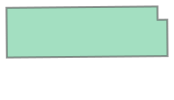

In [74]:
geopandas.read_file('../data/network/polyBuildings.shp')['geometry']

In [75]:
from shapely.geometry import Point
point = Point(0.5, 0.5)
print(geopandas.read_file('../data/network/polyBuildings.shp')['geometry'][0].contains(point))

False


In [90]:
poly_df_geo = geopandas.read_file('../data/network/polyBuildings.shp')[['CAANtext','geometry']]

In [91]:
total_edge_end_point = set()
for key, values in mh_graph.edges.items():
    total_edge_end_point.add(key)
    for val in values: total_edge_end_point.add(val)
total_edge_end_point

{(6256781.619515255, 1899074.9698790014),
 (6253916.278461173, 1897086.3232657611),
 (6260941.575762257, 1900579.581043005),
 (6262046.730376095, 1901774.999255836),
 (6263262.974662751, 1900302.4831719995),
 (6256695.370343924, 1900823.6494525075),
 (6259534.493602678, 1899515.527068749),
 (6259534.5874345, 1899515.435205415),
 (6259006.363753423, 1901841.978780672),
 (6259006.346693084, 1901841.9810772538),
 (6259313.291617259, 1899321.5054751784),
 (6256625.97514151, 1902682.5620732605),
 (6263984.016527757, 1898931.334995672),
 (6256750.586112753, 1904226.8864124268),
 (6260940.097746834, 1902614.2698870003),
 (6253674.101780176, 1896380.2219876647),
 (6260940.097746834, 1902614.2456088364),
 (6254692.423562422, 1896317.436352089),
 (6254692.817590505, 1896317.7080050856),
 (6256779.822274759, 1904138.546694085),
 (6261152.865365922, 1901595.2709407508),
 (6259262.9160618335, 1899457.736830011),
 (6260980.856851667, 1902970.407626167),
 (6257391.350251168, 1902508.8435886651),
 (62

In [101]:
df = pd.DataFrame(total_edge_end_point)
df['CAANtext'] = ""
df

0             1 CAANtext
0     6.256782e+06  1.899075e+06         
1     6.253916e+06  1.897086e+06         
2     6.260942e+06  1.900580e+06         
3     6.262047e+06  1.901775e+06         
4     6.263263e+06  1.900302e+06         
...            ...           ...      ...
4584  6.259888e+06  1.902727e+06         
4585  6.258902e+06  1.900337e+06         
4586  6.253996e+06  1.898006e+06         
4587  6.259116e+06  1.900403e+06         
4588  6.262310e+06  1.898558e+06         

[4589 rows x 3 columns]

In [102]:
edges_point_df = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df[0], df[1]))

In [122]:
building_map = defaultdict(set)
for index, row in poly_df_geo.iterrows():
    pip_mask = edges_point_df.within(row['geometry'])
    for idx,r in edges_point_df[pip_mask].iterrows():
        building_map[(r[0],r[1])].add(row['CAANtext'])
building_map

defaultdict(set,
            {(6253366.181464255, 1895850.3034280837): {'7094'},
             (6253377.822845176, 1895982.9029004276): {'6270'},
             (6253386.284770504, 1895782.8327625096): {'7094'},
             (6253412.823759422, 1896284.3573500067): {'6360'},
             (6253414.335239336, 1896279.4167430848): {'6360'},
             (6253416.863449514, 1896344.803423345): {'6360'},
             (6253418.424141929, 1896475.8907595873): {'6338'},
             (6253427.77878201, 1896074.2744368315): {'6285'},
             (6253433.19773443, 1896561.810535252): {'6323'},
             (6253434.004491344, 1896198.2312099189): {'6331'},
             (6253435.583884507, 1896568.9755471647): {'6323'},
             (6253470.053959921, 1896198.3647398353): {'6331'},
             (6253491.173340261, 1896174.4835540056): {'6331'},
             (6253527.708372176, 1895739.1035192609): {'6328'},
             (6253529.454759762, 1895739.049057424): {'6328'},
             (6253531.900621

In [118]:
'7373' in building_map.values()

False

In [126]:
poly_df_geo[poly_df_geo['CAANtext']=='7373'].geometry.contains(Point((6259277.108290672, 1899223.8288332522)))

549    False
dtype: bool

In [155]:
test_geo1 = mh_graph.df_pipe[mh_graph.df_pipe['UCSD_ID'] == "S02149"]
# test_mh1 = mh_graph.df_manhole[mh_graph.df_manhole['UCSD_ID'] == 'C3M110']['geometry'].iloc[0]
test_geo1

OBJECTID UCSD_ID STATUS      PRESSURE  SIZE MATERIAL   IE_UP   IE_DN  \
1527      1625  S02149      N  GRAVITY MAIN   4.0      PVC    0.00    0.00   
2282      2458  S02149      N  GRAVITY MAIN   4.0      PVC    0.00    0.00   
2285      2461  S02149      N  GRAVITY MAIN   8.0      PVC  348.51  345.66   

         SLOPE  INSTALL_DA  ...                                GLOBALID  \
1527  0.000000  2010-12-01  ...  {2A707583-3070-4989-925A-52FC5FDA791D}   
2282  0.000000  2018-05-16  ...  {CC345628-2784-4C29-AC4B-23CA9C649B88}   
2285  0.010011  2018-05-16  ...  {A1474ED0-FD91-478A-ACC0-18A12DC19CB5}   

     FLOWDIRECT FLOWDIRE_1 FLOWDIRE_2 FLOWDIRE_3  Shape_Le_1 FLOWDIRE_4  \
1527          1          1          1          1   11.763677          1   
2282          1          1          1          1   65.726346          1   
2285          1          1          1          1  288.696281          1   

      FLOWDIRE_5 FLOWDIRE_6                                           geometry  
1527           1          1  LINESTRING (6259277.108 1899223.829, 6259287.8...  
2282           1          1  LINESTRING (6264226.321 1899416.360, 6264197.7...  
2285           1          1  LINESTRING (6264197.783 1899475.568, 6264069.3...  

[3 rows x 38 columns]

In [156]:
mh_graph.build_to_coords_map['7373']

{(6264228.07640709, 1899412.7756338418)}

In [157]:
[list(elem.coords) for elem in test_geo1['geometry']]

[[(6259277.108290672, 1899223.8288332522),
  (6259287.862862334, 1899223.8383476734),
  (6259288.55052501, 1899224.576863259)],
 [(6264226.321489334, 1899416.3599442542),
  (6264197.783488676, 1899475.5675030053)],
 [(6264197.783488676, 1899475.5675030053),
  (6264069.345425338, 1899475.5376474261),
  (6263937.816488922, 1899475.5071356744),
  (6263909.087215677, 1899475.5005740076)]]